# Convolutional Neural Network Exercise Tasks

## Task 1: Data Understanding and Visualization

1. Load and visualize images from the dataset:
   - Get the list of class directories from the train folder
   - Select one image randomly from each class
   - Display the images in a grid format with two rows using matplotlib

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Level 6/AI & ML/Worksheets/Worksheet-5/FruitinAmazon.zip'
extract_to_path = '/content/drive/MyDrive/Level 6/AI & ML/Worksheets/Worksheet-5/FruitinAmazon'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

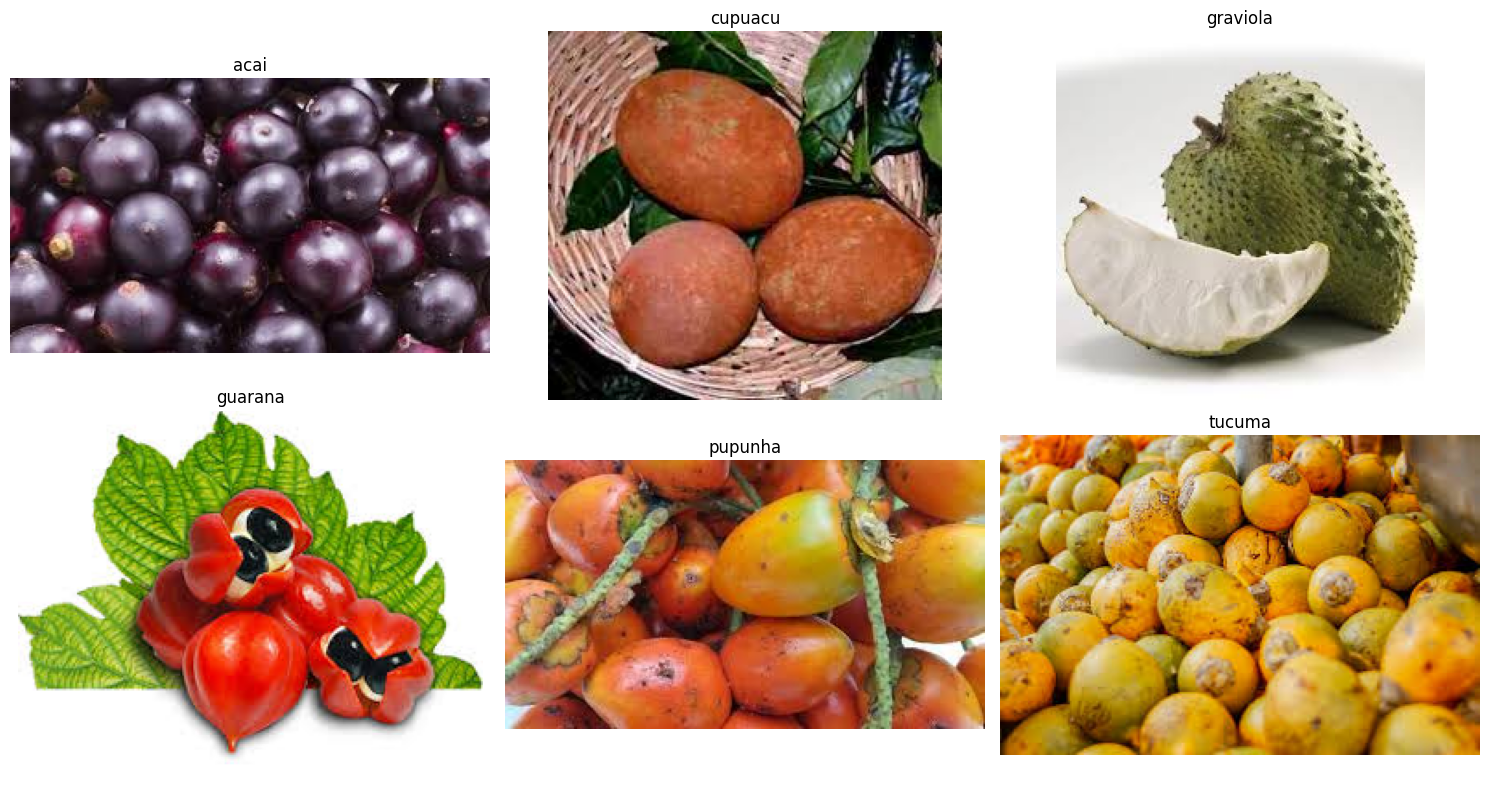

In [41]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset paths
train_dir = "/content/drive/MyDrive/Level 6/AI & ML/Worksheets/Worksheet-5/FruitinAmazon/FruitinAmazon/train/"
test_dir = "/content/drive/MyDrive/Level 6/AI & ML/Worksheets/Worksheet-5/FruitinAmazon/FruitinAmazon/test/"

# Get list of class directories from the train folder
class_dirs = sorted(os.listdir(train_dir))

# Select one image randomly from each class and store them
selected_images = []
class_names = []

for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_path)

    # Select a random image from this class
    random_image = random.choice(image_files)
    img_path = os.path.join(class_path, random_image)

    # Open and store the image
    img = Image.open(img_path)
    selected_images.append(img)
    class_names.append(class_name)

# Display the images in a grid format with two rows
num_classes = len(class_dirs)
num_cols = (num_classes + 1) // 2  # Ceiling division for odd number of classes
fig, axes = plt.subplots(2, num_cols, figsize=(15, 8))

for i, (img, class_name) in enumerate(zip(selected_images, class_names)):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

# Turn off axes for any unused subplots
for i in range(len(selected_images), 2 * num_cols):
    row = i // num_cols
    col = i % num_cols
    if row < 2 and col < num_cols:
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


2. Check for corrupted images:
   - Write a script that verifies whether images in the train directory are valid
   - If any corrupted images are found, remove them and print a message showing which images were removed
   - If no corrupted images are found, print "No Corrupted Images Found"
   - Hint: Use Image.open() to attempt loading each image and catch IOError or SyntaxError

In [42]:
# Initialize counter for corrupted images
corrupted_images = []

# Walk through all files in the train directory
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(root, file)
            try:
                # Try to open the image
                with Image.open(img_path) as img:
                    # Verify image is valid by loading it
                    img.verify()
                    # Also try to load the image data
                    with Image.open(img_path) as img_load:
                        img_load.load()
            except (IOError, SyntaxError, OSError) as e:
                # If there's an error, the image is corrupted
                corrupted_images.append(img_path)
                print(f"Corrupted image found: {img_path}")
                # Remove the corrupted image
                os.remove(img_path)

# Print summary
if corrupted_images:
    print(f"\nRemoved {len(corrupted_images)} corrupted images:")
    for img in corrupted_images:
        print(f" - {img}")
else:
    print("No Corrupted Images Found")

No Corrupted Images Found


## Task 2: Loading and Preprocessing Image Data

- Use tf.keras.preprocessing.image_dataset_from_directory to load the datasets
- Apply proper preprocessing including:
  - Resizing images to a consistent size (e.g., 128×128)
  - Normalizing pixel values by scaling them to [0, 1]
  - Creating separate training and validation datasets
  - Using appropriate batch size
  - Implementing data augmentation (optional)

In [43]:
import tensorflow as tf

# Define image size and batch size
img_height = 128  # Example image height
img_width = 128  # Example image width
batch_size = 32
validation_split = 0.2  # 80% training, 20% validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1.0 / 255)  # Normalize pixel values to [0, 1]

# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    interpolation="nearest",
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset="training",
    seed=123,
)

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    interpolation="nearest",
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset="validation",
    seed=123,
)

# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


## Task 3: Implement a CNN

Implement a CNN with the following structure:

**Convolutional Architecture:**
- Convolutional Layer 1:
  - Filter Size: (3, 3)
  - Number of Filters: 32
  - Padding: same
  - Stride: 1
  - Activation: ReLU
- Pooling Layer 1:
  - Max pooling with size (2, 2) and stride 2
- Convolutional Layer 2:
  - Filter Size: (3, 3)
  - Number of Filters: 32
  - Padding: same
  - Stride: 1
  - Activation: ReLU
- Pooling Layer 2:
  - Max pooling with size (2, 2) and stride 2

**Fully Connected Network Architecture:**
- Flatten Layer
- Hidden Layer 1: 64 neurons
- Hidden Layer 2: 128 neurons
- Output Layer: num_classes neurons (number of classes in the dataset)

In [44]:
from tensorflow.keras import layers, models

# Get the number of classes from our train_ds
num_classes = len(class_dirs)

# Build the CNN model
model = models.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    # Pooling Layer 1
    layers.MaxPooling2D((2, 2), strides=2),

    # Convolutional Layer 2
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    # Pooling Layer 2
    layers.MaxPooling2D((2, 2), strides=2),

    # Flatten Layer
    layers.Flatten(),

    # Hidden Layer 1
    layers.Dense(64, activation='relu'),

    # Hidden Layer 2
    layers.Dense(128, activation='relu'),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

## Task 4: Compile and Train the Model

- Compile the model with:
  - An appropriate optimizer (e.g., Adam)
  - Appropriate loss function (e.g., sparse categorical crossentropy)
  - Accuracy as the evaluation metric
- Train the model using:
  - model.fit() function
  - Batch size of 16
  - 250 epochs
  - Validation dataset for validation
  - Callbacks for ModelCheckpoint and EarlyStopping


In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint_cb = ModelCheckpoint(
    'best_model.h5', save_best_only=True, monitor='val_loss', mode='min'
)
early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True, monitor='val_loss', mode='min'
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.1655 - loss: 2.1717

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1623 - loss: 2.2187 - val_accuracy: 0.2222 - val_loss: 1.5358
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.2422 - loss: 1.8629 - val_accuracy: 0.0000e+00 - val_loss: 1.7217
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.3160 - loss: 1.6980 - val_accuracy: 0.0000e+00 - val_loss: 1.7470
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - accuracy: 0.2166 - loss: 1.6496 - val_accuracy: 0.0000e+00 - val_loss: 1.8751
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - accuracy: 0.2865 - loss: 1.5421 - val_accuracy: 0.0556 - val_loss: 1.8016
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 911ms/step - accuracy: 0.3872 - loss: 1.4485 - val_accuracy: 0.0556 - val_loss: 1.7284
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.4797 - loss: 1.2299

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 569ms/step - accuracy: 0.4813 - loss: 1.2299 - val_accuracy: 0.3889 - val_loss: 1.3552
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5891 - loss: 1.1219

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step - accuracy: 0.5946 - loss: 1.1089 - val_accuracy: 0.6111 - val_loss: 1.2055
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.7807 - loss: 0.8004

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - accuracy: 0.7765 - loss: 0.8123 - val_accuracy: 0.8333 - val_loss: 0.6681
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - accuracy: 0.8338 - loss: 0.6081 - val_accuracy: 0.3889 - val_loss: 1.2827
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8207 - loss: 0.5452 - val_accuracy: 0.7222 - val_loss: 0.7503
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9392 - loss: 0.3328

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 0.9440 - loss: 0.3248 - val_accuracy: 0.8333 - val_loss: 0.5229
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step - accuracy: 0.9674 - loss: 0.2564 - val_accuracy: 0.8333 - val_loss: 0.6293
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step - accuracy: 1.0000 - loss: 0.1392 - val_accuracy: 0.7778 - val_loss: 0.5903
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9595 - loss: 0.1178

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.9627 - loss: 0.1141 - val_accuracy: 0.8889 - val_loss: 0.3305
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9902 - loss: 0.0591

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9891 - loss: 0.0601 - val_accuracy: 0.9444 - val_loss: 0.2181
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 604ms/step - accuracy: 1.0000 - loss: 0.0438 - val_accuracy: 0.8333 - val_loss: 0.4000
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 523ms/step - accuracy: 1.0000 - loss: 0.0302 - val_accuracy: 0.8333 - val_loss: 0.5492
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 1.0000 - loss: 0.0240 - val_accuracy: 0.8333 - val_loss: 0.3076
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.8889 - val_loss: 0.2549
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.0193

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.9444 - val_loss: 0.1697
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8889 - val_loss: 0.2000
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.8333 - val_loss: 0.2614
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8333 - val_loss: 0.3252
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8333 - val_loss: 0.3556
Epoch 26/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.8333 - val_loss: 0.3735
Epoch 27/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8333 - val_loss: 0.3757
Epoch 28/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8333 - val_loss: 0.

## Task 5: Evaluate the Model

- Evaluate the model using model.evaluate() on the test set
- Record the test accuracy and loss

In [46]:
# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    interpolation="nearest",
    batch_size=batch_size,
    shuffle=False,
)

# Apply the normalization (Rescaling) to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test accuracy and loss
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7667 - loss: 0.7625
Test Loss: 0.7624826431274414
Test Accuracy: 0.7666666507720947


## Task 6: Save and Load the Model

- Save the trained model to an .h5 file using model.save()
- Load the saved model and re-evaluate its performance on the test set

In [47]:
# Save the trained model to an .h5 file
model.save('/content/drive/MyDrive/Level 6/AI & ML/Worksheets/Worksheet-5/fruit_classification_model.h5')

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Level 6/AI & ML/Worksheets/Worksheet-5/fruit_classification_model.h5')

# Re-evaluate the loaded model on the test dataset
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(test_ds)

# Print the re-evaluated test accuracy and loss
print(f"Re-evaluated Test Loss: {loaded_test_loss}")
print(f"Re-evaluated Test Accuracy: {loaded_test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step - accuracy: 0.7667 - loss: 0.7625
Re-evaluated Test Loss: 0.7624826431274414
Re-evaluated Test Accuracy: 0.7666666507720947


## Task 7: Predictions and Classification Report

- Use model.predict() to make predictions on test images
- Convert the probabilities to class labels using np.argmax()
- Generate a classification report using sklearn.metrics.classification_report

In [48]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions on the test dataset
predictions = model.predict(test_ds)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
              precision    recall  f1-score   support

        acai       0.80      0.80      0.80         5
     cupuacu       0.75      0.60      0.67         5
    graviola       0.56      1.00      0.71         5
     guarana       0.83      1.00      0.91         5
     pupunha       1.00      0.80      0.89         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.77        30
   macro avg       0.82      0.77      0.76        30
weighted avg       0.82      0.77      0.76        30



## Expected Deliverables

- Complete code for building, training, evaluating, saving, and loading the model
- Graphs showing the training and validation loss and accuracy
- Classification report on test data
- Saved .h5 model file


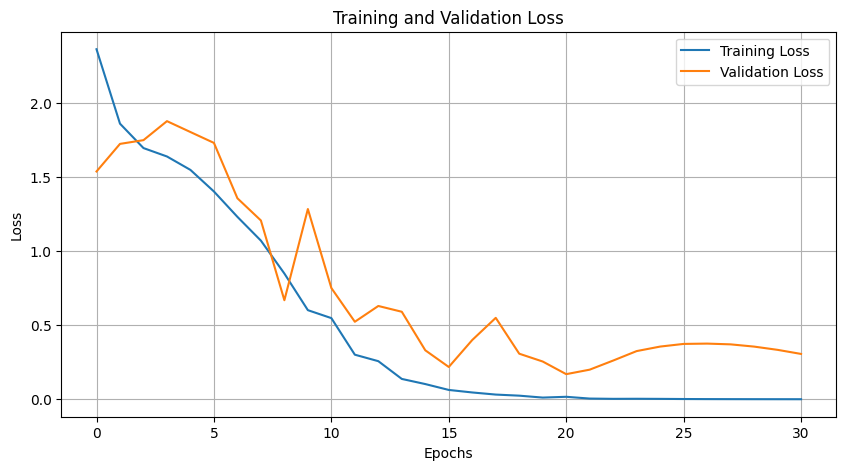

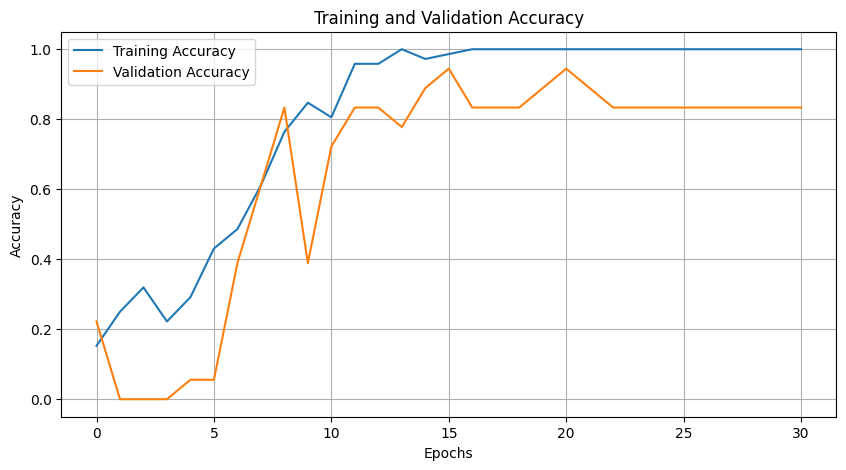

In [49]:
import matplotlib.pyplot as plt

# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a figure for the loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Create a figure for the accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()